In [34]:
import numpy as np
from shapely.geometry import Polygon, Point
import geopandas as gpd
import geoplot
import wget
from glob import glob
import zipfile
import pandas as pd
import pyarrow.parquet as pq
import os
from timeit import default_timer as timer
import folium
import socket
import seaborn as sns
import matplotlib.pyplot as plt
import pycountry
from folium.plugins import HeatMap
import branca.colormap
from collections import defaultdict
import webbrowser

r = os.system('python -c "import matplotlib.pyplot as plt;plt.figure()"')
if r != 0:
    import matplotlib
    matplotlib.use('Agg')
else:
    get_ipython().magic('matplotlib inline')

In [30]:
print('Hostname:', socket.gethostname())
if 'samuel' in socket.gethostname().lower():
    path_to_data='../data'
else:
    path_to_data='/scratch/spf248/twitter/data'
path_to_users=os.path.join(path_to_data,'users')
path_to_locations=os.path.join(path_to_data,'locations/profiles')
path_to_fig=os.path.join(path_to_data,'../fig')
print(path_to_users)
print(path_to_locations)
print(path_to_fig)

Hostname: c41-10
/scratch/spf248/twitter/data/users
/scratch/spf248/twitter/data/locations/profiles
/scratch/spf248/twitter/data/../fig


In [3]:
print('Import Users By Account Locations')
start = timer()

l = []
for filename in sorted(glob(os.path.join(path_to_users,'user-ids-by-account-location-verified/*.json'))):
    try:
        df = pd.read_json(filename,lines=True)
        l.append(df)
    except:
        print('error importing', filename)
users_by_account_location=pd.concat(l, axis=0, ignore_index=True)
users_by_account_location=users_by_account_location.set_index('user_location')['user_id']
users_by_account_location=users_by_account_location.apply(eval).apply(lambda x:[str(y) for y in x])
users_by_account_location=users_by_account_location.apply(len)
print('# Locations:', len(users_by_account_location))
print('# Users Total:', users_by_account_location.sum())

locations=pd.read_pickle(os.path.join(path_to_locations,'account-locations-identified.pkl'))
print('# Locations:', len(locations))

end = timer()
print('Computing Time:', round(end - start), 'sec')

Import Users By Account Locations
# Locations: 39779
# Users Total: 92088032
Computing Time: 208 sec


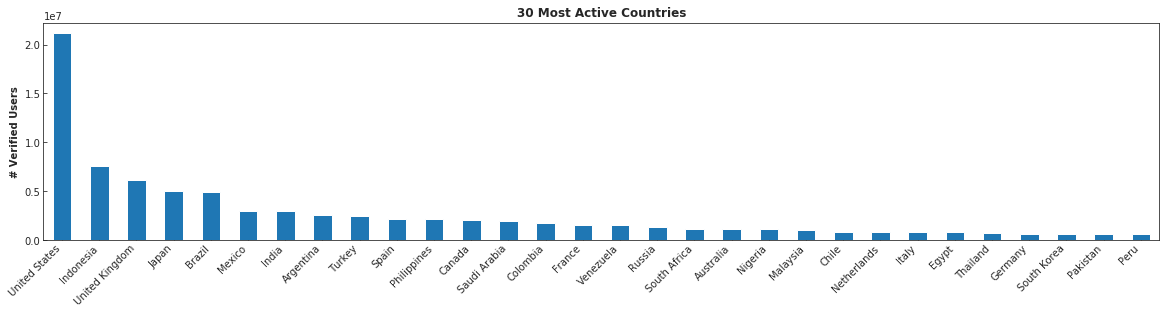

In [31]:
with sns.axes_style("white"):
    sns.set_style("ticks")

    fig,ax = plt.subplots(figsize=(20,4))
    
    data_to_plot=pd.merge(
    users_by_account_location.reset_index(),
    locations.rename(columns={'LOCATION':'user_location'}))[[
    'user_id', 
    'latitude', 
    'longitude',
    'country_long',
    'locality_long',]].groupby('country_long')['user_id'].sum().sort_values(ascending=False).head(30)
    
    data_to_plot.plot(ax=ax,kind='bar')
        
    ax.set_ylabel('# Verified Users',fontweight='bold')
    ax.set_xlabel('')
    ax.tick_params(which='both',direction='in',pad=3)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha='right')
    ax.locator_params(axis='y',nbins=5)
    ax.set_title('30 Most Active Countries',fontweight='bold')
#     ax.set_yscale('log')
    
plt.savefig(os.path.join(path_to_fig,'most-active-countries.pdf'),bbox_inches='tight')

In [32]:
print("# Identified Cities:", locations['locality_long'].unique().shape[0])

print("# Users Identified At the City Level:")
print(pd.merge(users_by_account_location.reset_index(),
locations.rename(columns={'LOCATION':'user_location'})).groupby('locality_long')['user_id'].sum().sum())

# Identified Cities: 7701
# Users Identified At the City Level:
57067437


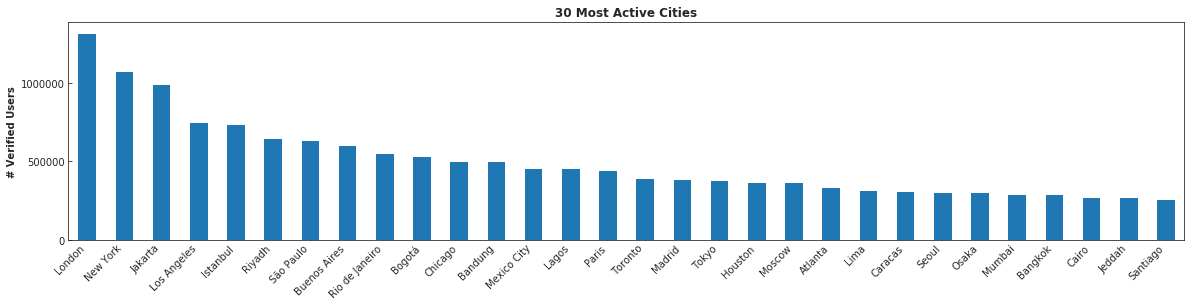

In [33]:
with sns.axes_style("white"):
    sns.set_style("ticks")

    fig,ax = plt.subplots(figsize=(20,4))
    
    data_to_plot=pd.merge(
    users_by_account_location.reset_index(),
    locations.rename(columns={'LOCATION':'user_location'}))[[
    'user_id', 
    'latitude', 
    'longitude',
    'country_long',
    'locality_long',]].groupby('locality_long')['user_id'].sum().sort_values(ascending=False).head(30)
    
    data_to_plot.plot(ax=ax,kind='bar')
        
    ax.set_ylabel('# Verified Users',fontweight='bold')
    ax.set_xlabel('')
    ax.tick_params(which='both',direction='in',pad=3)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha='right')
    ax.locator_params(axis='y',nbins=5)
    ax.set_title('30 Most Active Cities',fontweight='bold')
#     ax.set_yscale('log')
    
plt.savefig(os.path.join(path_to_fig,'most-active-cities.pdf'),bbox_inches='tight')

In [46]:
users_by_city=pd.merge(
users_by_account_location.reset_index(),
locations.rename(columns={'LOCATION':'user_location'})).groupby('locality_long').agg(
{'latitude':'first','longitude':'first','country_short':'first','country_long':'first','user_id':'sum'}).rename(
columns={'user_id':'n_users'}).sort_values(by='n_users',ascending=False).reset_index()

In [47]:
users_by_city.head()

,locality_long,latitude,longitude,country_short,country_long,n_users
0,London,51.507351,-0.127758,GB,United Kingdom,1319957
1,New York,40.783060,-73.971249,US,United States,1076964
2,Jakarta,-6.208763,106.845599,ID,Indonesia,996785
3,Los Angeles,34.052234,-118.243685,US,United States,751167
4,Istanbul,41.008238,28.978359,TR,Turkey,738721


# City-level Active Users Per Country

In [68]:
country='BR'

In [85]:
map_city = folium.Map(
location = [users_by_city.loc[users_by_city.country_short==country,'latitude'].mean(), 
            users_by_city.loc[users_by_city.country_short==country,'longitude'].mean()], 
zoom_start=4, 
tiles='cartodbpositron',
)

for i, (city, lat, lon, n_users) in enumerate(zip(
users_by_city.loc[users_by_city.country_short==country,'locality_long'],
users_by_city.loc[users_by_city.country_short==country,'latitude'],
users_by_city.loc[users_by_city.country_short==country,'longitude'],
users_by_city.loc[users_by_city.country_short==country,'n_users'])):
    folium.CircleMarker(
    [lat, lon],
    radius=0.05*np.sqrt(n_users),
    fill=True,
    fill_opacity=0.5,
    color='k',
    tooltip=city.title() + ' (' + '{:,}'.format(n_users) + ' Users)'
    ).add_to(map_city)

map_city.save(os.path.join(path_to_fig,'users-per-city-'+country+'.html'))

In [86]:
map_city